In [1]:
import pandas as pd
import numpy as np
import datetime
from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm

In [2]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')

In [3]:
sales_train.head()
# sales_train.item_price.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
# merge sales_train, items, shios, item_categories
df = pd.merge(sales_train, items, on='item_id', how='left')
df1 = pd.merge(df, shops, on='shop_id', how='left')
df2 = pd.merge(df1, item_categories, on='item_category_id', how='left')
df2.head()

In [ ]:
# drop unnecessary columns
df_sales = df2.copy()
df_sales.drop(['item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
df_sales.head()

In [ ]:
# check duplicates
print(df_sales.duplicated().sum())
print(df_sales.shape)

# drop duplicates
df_sales.drop_duplicates(inplace=True)
df_sales.duplicated().sum()

In [ ]:
# check missing values
df_sales.isna().sum()

In [ ]:
# check dataset
df_sales.describe()

In [ ]:
# drop the abnormal values for item_price and ieem_cnt_day
index = df_sales[(df_sales.item_price < 0) | (df_sales.item_cnt_day < 0)].index
df_sales.drop(index, inplace=True)

In [ ]:
df_sales.describe()

##  EDA

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
df_sales.head()

In [ ]:
# create a new column for total sales
df_sales = df_sales.assign(total_sales = df_sales.item_price * df_sales.item_cnt_day)

In [ ]:
# df_sales.head()
df_sales.query('item_cnt_day > 1000')

In [ ]:
monthly_sales = df_sales.pivot_table(index='date_block_num', values='item_cnt_day', aggfunc='sum')
monthly_sales.head()

#  plot the monthly sales volume
# px.scatter(monthly_sales, x=monthly_sales.index, y='item_cnt_day', title='Daily Sales')

# #  plot line plot for monthly sales volume
# px.line(monthly_total_sales, x=monthly_total_sales.index, y='total_sales', title='monthly_total_sales')

In [ ]:
monthly_revenu = df_sales.pivot_table(index='date_block_num', values='total_sales', aggfunc='sum')
monthly_revenu.head()

In [ ]:
# compare monthly sales volume and monthly revenue
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=False)

fig1 = sns.scatterplot(x=monthly_sales.index, y='item_cnt_day', data=monthly_sales, ax=axes[0])
fig2 = sns.lineplot(x=monthly_revenu.index, y='total_sales', data=monthly_revenu, ax=axes[1])


In [ ]:
# compare monthly sales volume and monthly revenue
fig = make_subplots(rows=1, cols=2, subplot_titles=("Monthly Sales Volumn", "Monthly Revenu"))
fig.add_trace(go.Scatter(x=monthly_sales.index, y=monthly_sales.item_cnt_day, name='Monthly Sales Volumn'), row=1, col=1)
fig.add_trace(go.Line(x=monthly_revenu.index, y=monthly_revenu.total_sales, name='Monthly Revenu'), row=1, col=2)

We can see that there is a downward trend towards 2015, most likely due to the recession. Meanwhile, we can see that the trend is not linear, and there is a lot of noise in the data. We can also see that there is a seasonal component to the data, with a peak in the summer months.

Attention --> The data is not stationary, and we will need to use differencing to make it stationary.

In [ ]:
#  top sales shops
sns.countplot(df_sales, y='shop_name', order=df_sales.shop_name.value_counts().iloc[:10].index)

In [ ]:
# show the frequency of sales among shops
plt.figure(figsize=(10, 16))
sns.countplot(y=df_sales['shop_name'], order=df_sales.shop_name.value_counts().index, palette='Set2')
plt.xlabel('number of sold items')
plt.ylabel('Shop Name')

In [ ]:
df_sales.shop_name.value_counts().index[0]

In [ ]:
items_per_shop = df_sales.shop_name.value_counts().to_frame().reset_index().rename(columns={'index': 'shop_name', 'shop_name': 'num_items'})
# check the outlier shops
px.box(items_per_shop, x='num_items')



In [ ]:
# drop the outlier shops
index = items_per_shop.query('num_items > 117000').index
index 

Number of items sold per shop has a big variance, and we can see that there are some shops that are outliers. We can also see that there are some shops that are selling fewer items than others.

In [ ]:
#  top sales items
sns.countplot(df_sales, y='item_name', order=df_sales.item_name.value_counts().iloc[:10].index)

In [ ]:
# most popular items in each shop 
# Msoled_items = df_sales.groupby(['shop_name', 'item_name']).size().reset_index(name='count')
# Msoled_items

# msoled_item_shop.item_name.unique()
# msoled_item_shop.item_name.mode().values

# get the most sold items in each shop
most_sold_items = df_sales.pivot_table(index='shop_name', columns='item_name', values='item_cnt_day', aggfunc='sum')
name_item = most_sold_items.idxmax(axis=1)
num_item = most_sold_items.max(axis=1)
msoled_item_shop = pd.concat([name_item, num_item], axis=1)
msoled_item_shop.columns = ['item_name', 'item_cnt_day']
msoled_item_shop.sort_values(by='item_cnt_day', ascending=False, inplace=True)
msoled_item_shop.head()

In [ ]:
msoled_item_shop.item_name.mode()

We find that Фирменный пакет майка 1С Интерес белый (34*42) is the most popular item, it might due to the appropriate price and that there are some items that are outliers.

In [ ]:
# top sale category
sns.countplot(y=df_sales.item_category_name, order=df_sales.item_category_name.value_counts().iloc[:10].index)

It is interesting to see that the most popular item category is DVD. 

In [ ]:
# most sold items in each category 
maxSold_items = df_sales.pivot_table(index='item_category_name', columns='item_name', values='item_cnt_day', aggfunc='sum')
# create a new dataframe to store the most sold items in each category
name_item = maxSold_items.idxmax(axis=1)
num_item = maxSold_items.max(axis=1)
df_maxSold_item = pd.concat([name_item, num_item], axis=1)
df_maxSold_item.columns = ['item_name', 'item_num']
df_maxSold_item.sort_values(by='item_num', ascending=False, inplace=True)
df_maxSold_item.head(10)


We would like to know the most popluar item in each category, that would help us to develop a recommandation system regarding up selling and cross selling.

In [ ]:
# rename the columns name of total_sales to revenu
df_sales.rename(columns={'total_sales':'revenue'}, inplace=True)

In [ ]:
# most revenue items in each category
maxSold_name = df_sales.pivot_table(index='item_category_name', columns='item_name', values='revenue', aggfunc='sum').idxmax(axis=1)
maxSold_num = df_sales.pivot_table(index='item_category_name', columns='item_name', values='revenue', aggfunc='sum').max(axis=1)
maxSold = pd.concat([maxSold_name, maxSold_num], axis=1)
maxSold.columns = ['item_name', 'revenue']
maxSold.sort_values(by='revenue', ascending=False, inplace=True)
maxSold.head(10)

It is important to know which item contributes the most to the total revenue for each category. We need to give more attention to these items.

In [ ]:
shop_monthly_sales = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day': 'sum'})
shop_monthly_sales

In [ ]:
shop_monthly_sales_total = []

for shop in shop_monthly_sales.shop_id.unique():
    current_shop = shop_monthly_sales.query('shop_id == @shop')
    shop_monthly_sales_total.append(go.Scatter(x=current_shop.date_block_num, y=current_shop.item_cnt_day, name=f'shop_id: {shop}'))
    
layout = go.Layout(title='Monthly Sales of Each Shop', xaxis={'title': 'Month'}, yaxis={'title': 'Sales'})
fig = go.Figure(data=shop_monthly_sales_total)
iplot(fig)
    

En general, there is a downward trend towards 2015. Peaks can be seen around december, we assume that people receive more money thank to the yearly premium and spend more during the new year. Meanwhile, we notice that shop_id 54 is an outlier, it is showing different behavior than the other shops.

In [ ]:
df_sales.shop_name.unique()

In [ ]:
# Extract the city name from the shop name and write it to the cities list
cities = []
for i in df_sales['shop_name']:
    city = i.split(' ')[0]
    if city[0] == '!':
        city = i.split('!')[1].split(' ')[0]
        cities.append(city)
    elif city == 'Интернет-магазин':
        cities.append('Интернет')
    elif city == 'Цифровой':
        cities.append('Интернет')
    else:
        cities.append(city)

In [ ]:
city = df_sales.shop_name.unique()[:10]
city

In [ ]:
df_sales['city'] = cities
df_sales.head()

In [ ]:
top10City = df_sales.city.value_counts().iloc[:10].to_frame().reset_index()
top10City.columns = ['city', 'count']
top10City

In [ ]:
# plot the top 10 cities sales distinguishing by item category

px.bar(top10City, x='city', y='count', color='city', title='Top 10 Cities Sales', color_discrete_sequence=px.colors.qualitative.Dark24)
# px.bar(top10City, x='city', y='count', title='Top 10 Cities Sales')
# sns.barplot(data=df_sales, x='city', y='item_cnt_day')


In [ ]:
# plot the top 10 cities sales distinguishing by item category
catSales_per_city = df_sales.groupby(['city', 'item_category_name']).item_cnt_day.sum().to_frame().reset_index().sort_values(by='item_cnt_day', ascending=False).reset_index(drop=True)
catSales_per_city

In [ ]:
top10City_name = top10City.city.unique()
catSales_per_city10 = catSales_per_city.query('city in @top10City_name')
catSales_per_city10

In [ ]:
# plot the cities sales distinguishing by item category
px.bar(catSales_per_city10, x='city', y='item_cnt_day', color='item_category_name', title='Top 10 Cities Sales', color_discrete_sequence=px.colors.qualitative.Dark24)

In [ ]:
# # get the top 3 item categories in top 10 sales city -- to do 

# top3cat ={city: df_sales.query('city == @city').item_category_name.value_counts().iloc[:3].to_frame().reset_index().values.tolist() 
#           for city in df_sales.city.unique()}
# top3cat


# top3cat_df = pd.DataFrame.from_dict(top3cat, orient='index')
# top3cat_df.columns = ['top 1', 'top2', 'top3']
# top3cat_df

# top3cat = df_sales.item_category_name.value_counts().iloc[:3].to_frame().reset_index()

# #  make it to a dataframe
# top3cat 


In [ ]:
# check thhe outlier of the item price
sns.boxplot(df_sales.item_price)

In [ ]:
# drop the outliers
df_sales.drop(df_sales[df_sales.item_price > 250000].index, inplace=True)

In [ ]:
sns.boxplot(df_sales.item_price)

In [ ]:
df_sales.info()

In [ ]:
df_sales.head()

## Feature Engineering

In [7]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


1. remove the neagtive values
2. remove the outliers
3. remove the duplicates 
4. remove unnecessary columns


In [10]:
# remove the negative values in sales train 
df_sales = sales_train.copy()
index = df_sales[(df_sales.item_cnt_day <0) | (df_sales.item_price <0)].index
df_sales.drop(index, inplace=True)

In [ ]:
# plot two subplot of box to check the outliers for item price and item count
fig = make_subplots(rows=1, cols=2, subplot_titles=('Item Price', 'Item Count'))
fig.add_trace(go.Box(y=df_sales.item_price, name='Item Price'), row=1, col=1)
fig.add_trace(go.Box(y=df_sales.item_cnt_day, name='Item Count'), row=1, col=2)

In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
# # select only rows of Novemeber 2013 and Novemeber 2014 to get the result of the test set
# train_df = sales_train[sales_train.date_block_num.isin([10, 22])]

In [35]:
train_df = sales_train.copy()
train_df.shape

(2935849, 6)

In [37]:
# # Eliminate outliers by droping data with standard deviation higher than 3 for item_cnt_day and item_price

train_df = train_df[(train_df.item_price < 3 * train_df.item_price.std()) & (train_df.item_cnt_day < 3 * train_df.item_cnt_day.std())]

# train_df = train_df[((train_df.item_price - train_df.item_price.mean()) < 3 *train_df.item_price.std()) & ((train_df.item_cnt_day - train_df.item_cnt_day.mean())/ 3* train_df.item_cnt_day.std())]
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [38]:
train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.440940e+06,2.440940e+06,2.440940e+06,2.440940e+06,2.440940e+06
mean,1.429625e+01,3.311330e+01,1.048877e+04,5.761500e+02,9.949720e-01
std,9.439630e+00,1.628581e+01,6.285502e+03,4.935148e+02,1.023724e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,6.000000e+00,2.200000e+01,4.808000e+03,2.200000e+02,1.000000e+00
50%,1.300000e+01,3.100000e+01,1.019100e+04,3.990000e+02,1.000000e+00
75%,2.200000e+01,4.800000e+01,1.601400e+04,7.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216800e+04,2.354230e+03,1.000000e+00


In [39]:
# eliminate negative value for item_cnt_day and item_price
index = train_df[(train_df.item_price < 0) | (train_df.item_cnt_day < 0)].index
train_df.drop(index, inplace=True)
train_df.shape

(2434865, 6)

In [40]:
print(train_df.duplicated().sum())
# drop the duplicated rows
train_df.drop_duplicates(inplace=True)
print(train_df.duplicated().sum())

6
0


In [41]:
# create a new column revenue
train_df = train_df.assign(revenue = train_df.item_price * train_df.item_cnt_day, inplace=True)

In [42]:
train_df.head() 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue,inplace
0,02.01.2013,0,59,22154,999.00,1.0,999.00,True
1,03.01.2013,0,25,2552,899.00,1.0,899.00,True
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05,True
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00,True
5,10.01.2013,0,25,2564,349.00,1.0,349.00,True


In [43]:
train_df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
revenue           0
inplace           0
dtype: int64

In [44]:
df_train2 = train_df.copy()

In [45]:
df_train2 = df_train2.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').fillna(0.0)


In [46]:
df_train2.reset_index(inplace=True)

In [47]:
df_train2.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,31,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,32,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,35,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_train2.shop_id.dtypes

dtype('int64')

In [48]:
# df_train2.shop_id = df_train2.shop_id.astype('str')
# df_train2.item_id = df_train2.item_id.astype('str')

print(df_train2.shop_id.dtype, df_train2.item_id.dtype)

int64 int64


In [49]:
df_train2.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,31,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,32,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,35,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [51]:
# add the item_category_id to the df_train
df_train2 = pd.merge(df_train2, items[['item_id', 'item_category_id']], on='item_id', how='left')
df_train2.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_id
0,0,31,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,0,32,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
2,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
3,0,35,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,0,36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37


In [52]:
df_train2.dtypes

shop_id               int64
item_id               int64
0                   float64
1                   float64
2                   float64
3                   float64
4                   float64
5                   float64
6                   float64
7                   float64
8                   float64
9                   float64
10                  float64
11                  float64
12                  float64
13                  float64
14                  float64
15                  float64
16                  float64
17                  float64
18                  float64
19                  float64
20                  float64
21                  float64
22                  float64
23                  float64
24                  float64
25                  float64
26                  float64
27                  float64
28                  float64
29                  float64
30                  float64
31                  float64
32                  float64
33                  

In [29]:
# Rearrange the columns
df_train2 = df_train2[['shop_id', 'item_id', 'item_category_id'] + list(range(34))]
df_train2.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,0.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,6.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,1.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model 1 for XGBregressor

In [68]:
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance

In [54]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_train2.drop([33], axis=1), df_train2[33], test_size=0.2, random_state=42)


In [55]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=800,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [56]:
xgb_model.fit(
    X_train, y_train
    , early_stopping_rounds=5
    , eval_set=[(X_test, y_test)]
    , verbose=False
)
print('Training: Done!')

xgb_predictions = xgb_model.predict(X_test)
print('Predictions: Done!')

c:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Training: Done!
Predictions: Done!


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

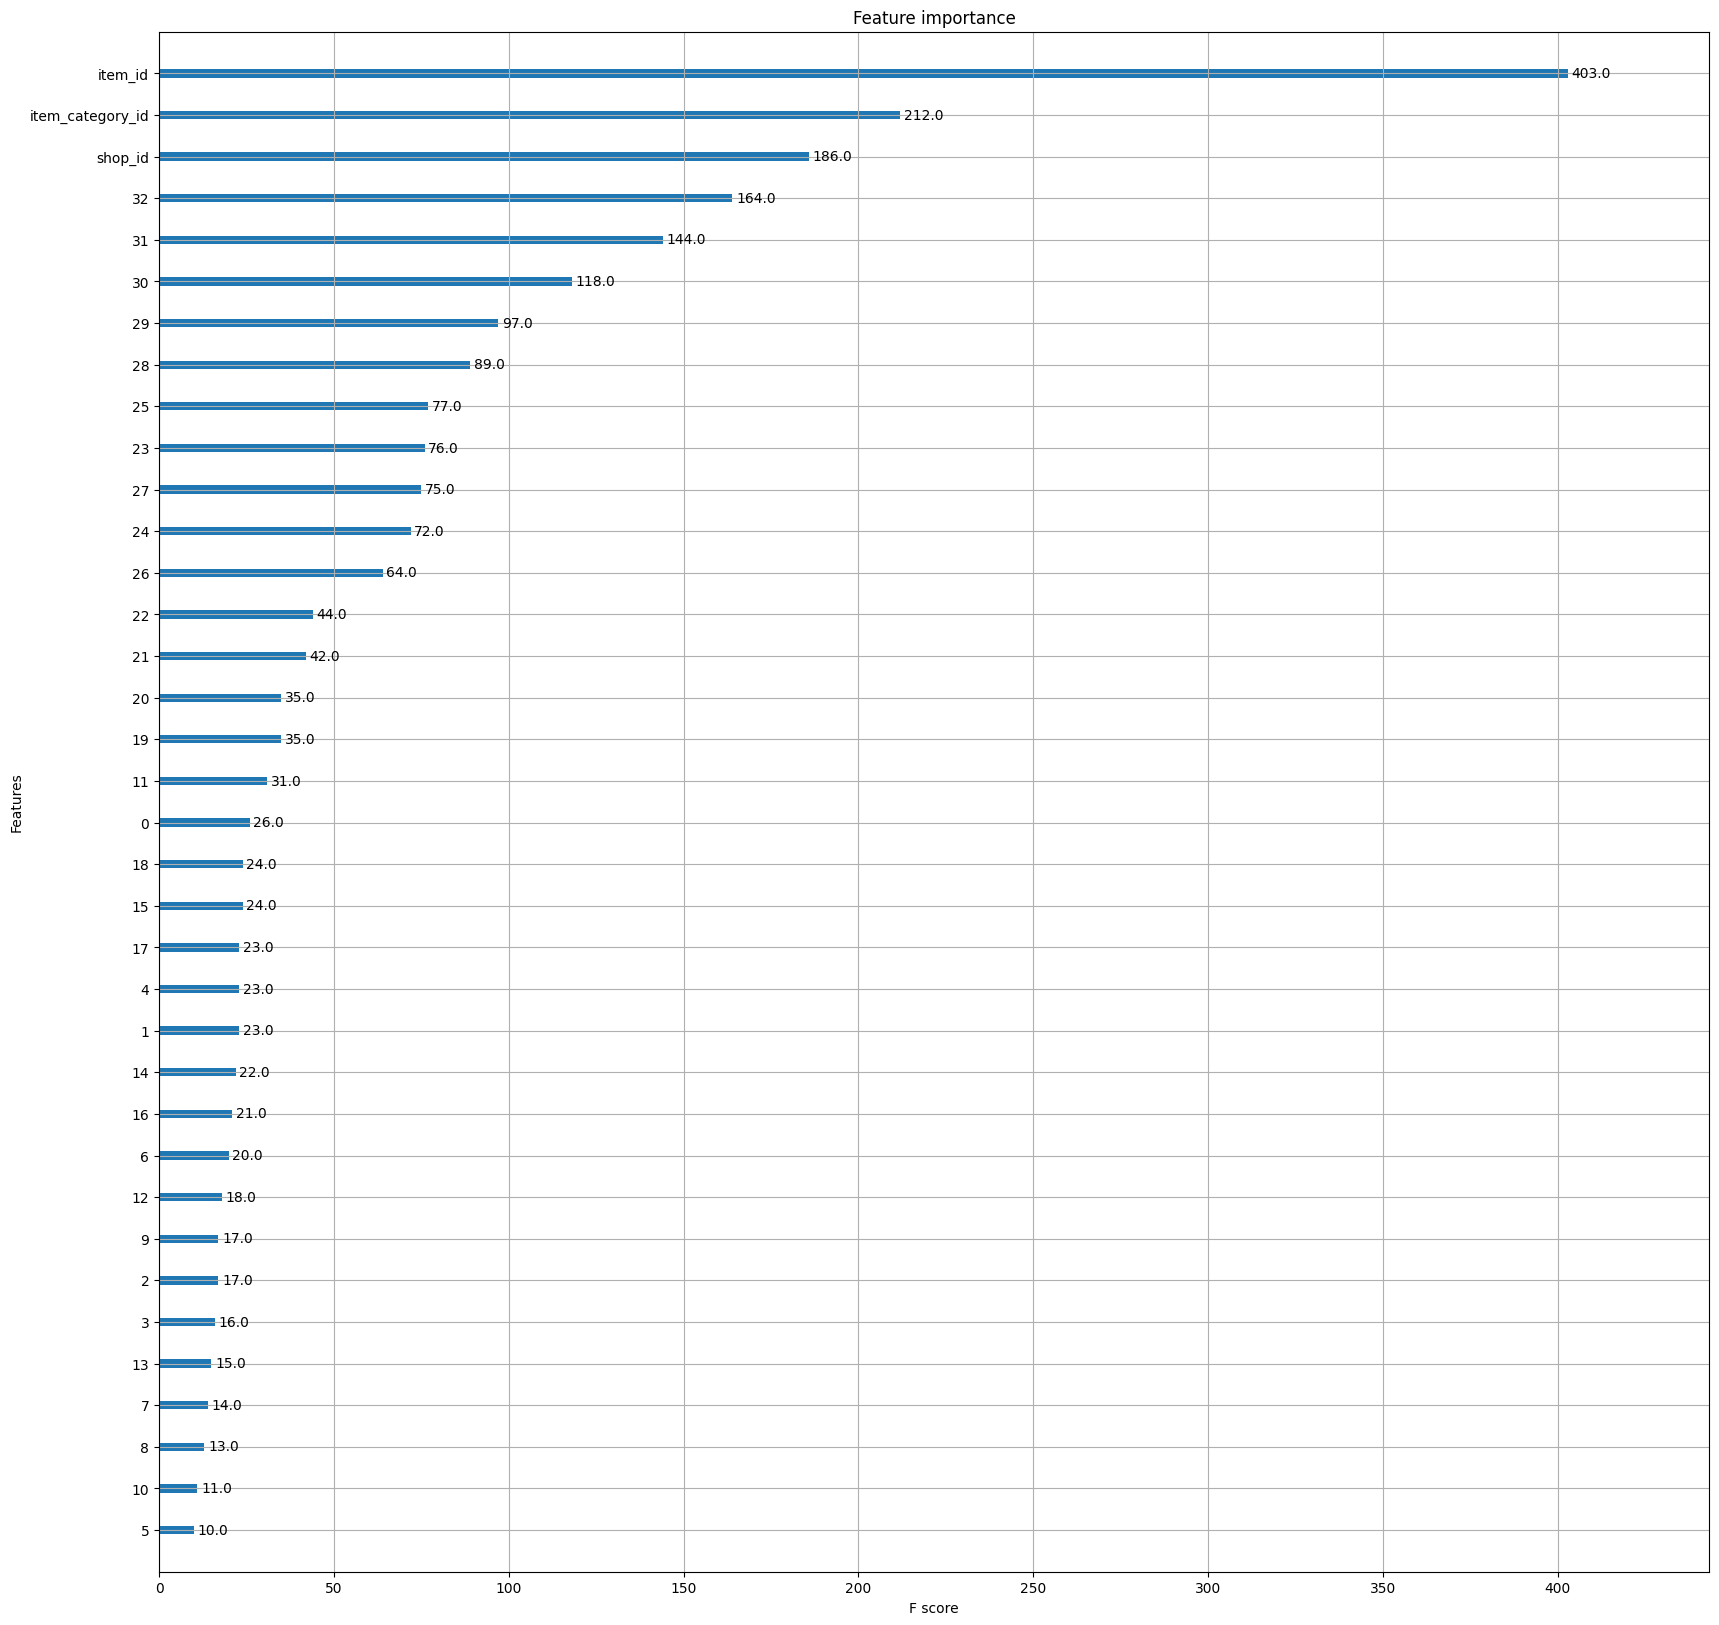

In [69]:
# Take a look at the importance of the features in the dataset
fig, ax = plt.subplots(figsize = (20, 20))
plot_importance(xgb_model, ax=ax)

In [57]:
# Evaluating
xgb_rmse = sqrt(mean_squared_error(xgb_predictions, y_test))
print('RMSE:', xgb_rmse)

RMSE: 0.3824910281897971


In [58]:
test = pd.read_csv('test.csv')
test_df = test.copy()

In [59]:
test.shape

(214200, 3)

In [60]:
test_df = test_df.merge(df_train2, on=['shop_id', 'item_id'], how='left').fillna(0.0)

In [61]:
test_df.drop('ID', axis=1, inplace=True)
test_df.drop(33, axis=1, inplace=True)

In [62]:
test_df.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,item_category_id
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,19.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,19.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
test_df.shape

(214200, 36)

In [63]:
# predict the test set
preds = xgb_model.predict(test_df)

In [64]:
output = pd.DataFrame({
    'ID': test.index
    ,  'item_cnt_month': preds
})

output.to_csv('submission3.csv', index=False)

## Model 2 for RandomForestRegressor

In [190]:
## select row of Novemeber 2013 and Novemeber 2014 to get the result of the test set
train_df = sales_train[sales_train.date_block_num.isin([10, 22])]
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1027580,06.11.2013,10,43,4420,299.0,1.0
1027581,16.11.2013,10,28,10033,199.0,1.0
1027582,14.11.2013,10,28,10051,149.0,1.0
1027583,22.11.2013,10,28,10051,149.0,1.0
1027584,30.11.2013,10,28,10051,149.0,1.0


In [191]:
train_df = train_df.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).item_cnt_day.sum()
train_df.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,10,2,33,2.0
1,10,2,97,1.0
2,10,2,482,2.0
3,10,2,791,1.0
4,10,2,944,1.0


In [192]:
X = train_df.copy()
y = train_df.iloc[:, :-1]

In [193]:
X.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,10,2,33,2.0
1,10,2,97,1.0
2,10,2,482,2.0
3,10,2,791,1.0
4,10,2,944,1.0


In [194]:
y = X.pop('item_cnt_day')
y

0         2.0
1         1.0
2         2.0
3         1.0
4         1.0
         ... 
97210     1.0
97211     6.0
97212    15.0
97213     1.0
97214     3.0
Name: item_cnt_day, Length: 97215, dtype: float64

## Model 2 for RandomForestRegressor with other features

In [208]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import RandomForestRegressor

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0
                                                    , train_size=0.80
                                                    , test_size=0.20)

In [210]:
# Creating Numerical Transformer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [211]:
# Bundling Preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, X.columns),
    ]
)

In [215]:
# Creating Model
rfg_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    criterion='squared_error',
    random_state=0,
)

rfg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rfg_model),
])

In [216]:
# Training and Predicting
rfg_pipeline.fit(X_train, y_train)
print('Training: Done!')
rfg_predictions = rfg_pipeline.predict(X_test)
print('Predictions: Done!')

Training: Done!
Predictions: Done!


In [217]:
# Calculating RMSE
from math import sqrt
rfg_rmse = np.sqrt(mean_squared_error(rfg_predictions, y_test))
print('RFG RMSE:', rfg_rmse)

RFG RMSE: 7.061070361673437


## Model 3 for XGBregressor with other features

In [232]:
# Creating the Model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.02,
    n_jobs=4,
    max_depth=8,
    min_child_weight=300
)

In [233]:
X_train

,date_block_num,shop_id,item_id
85020,22,47,14419
90976,22,54,13923
9830,10,17,10904
82724,22,44,21909
73660,22,31,11217
...,...,...,...
21243,10,28,5323
45891,10,56,2831
42613,10,54,1600
43567,10,54,9383


In [234]:
# Traning the Model and Making Predictions

xgb_model.fit(
    X_train, y_train
    , early_stopping_rounds=5
    , eval_set=[(X_test, y_test)]
    , verbose=False
)
print('Training: Done!')

xgb_predictions = xgb_model.predict(X_test)
print('Predictions: Done!')

c:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



Training: Done!
Predictions: Done!


In [220]:
# Evaluating
xgb_rmse = sqrt(mean_squared_error(xgb_predictions, y_test))
print('RMSE:', xgb_rmse)

RMSE: 8.620001609768979


In [236]:
# Calculating Clusters in the Test Dataset using K-Means
test.pop('ID')
test

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [38]:
# Adding November 2015 (34th month)
test['date_block_num'] = 34
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [ ]:

# Making Predictions and Saving Them into a File
predictions_test = rfg_pipeline.predict(test)
output = pd.DataFrame({
    'ID': test.index
    ,  'item_cnt_month': predictions_test
})

output.to_csv('submission.csv', index=False)

In [ ]:
#  try KMeans Model 
# from sklearn.cluster import KMeans
# criteria = []

# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=47, n_init=10)
#     kmeans.fit(X)
#     criteria.append(kmeans.inertia_)
    
    
# # plotting de criteria
# plt.plot(range(1, 11), criteria)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Criteria')
# plt.show()



# # We can see that the elbow is at 4, so we will use 4 clusters

# kmeans = KMeans(n_clusters=4, init='k-means++', random_state=47, n_init=10)

# X_temps = X.copy()
# X_temps['cluster'] = kmeans.fit_predict(X)
# X_temps


# sns.relplot(x='item_id', y='shop_id', hue='cluster', data=X_temps, height=6)